<a href="https://colab.research.google.com/github/khadija267/Load-Time-Series-Forecasting/blob/main/lsc_load_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Job Description
Create a model to forecast 15-min time-series electrical load data for a month.
We have 2 years of historical data to train the model, from 2021-present.
We need to create forecast for the next month.
The model also needs to take in temperature data for the location. We have the temperature data already.
We provide:
15 minute historical Time-series data for each of 3 sites
15 minute actual temperature data for the 3 sites



You provide:
15 minute load forecast for the next month


We provide:
15 minute historical Time-series data for each of 3 sites
15 minute actual temperature data for the 3 sites



You provide:
15 minute load forecast for the next month



Example. We have data for October 2021-March 2023. You provide a forecast for the month of April. (About 2976 data points, 15-minute)



There are 3 sites that we need to test this on now. Then we want the code to be able to run this in the future by our team.



We plan to use SARIMA, LSTM, etc. We specifically need to forecast one month, and would choose the method that produces the best results (on a different test month.)

In [44]:
#import libraries
#from google.colab import drive
#drive.mount('/content/helper.py')

from helper import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pylab
import missingno as msno
import seaborn as sns
import datetime
import statsmodels.api as sm
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
import statsmodels.graphics.tsaplots as sgt
import requests
import json
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
%matplotlib inline
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## 1. Data Investigation and Preparation

In [ ]:
lsc_load=pd.read_csv('lsc.csv')
lsc_temp = pd.read_csv('lsc_temp.csv')




### 1.1 Data Investigation

In [ ]:
lsc_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40895 entries, 0 to 40894
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Datetime MST  40895 non-null  object 
 1   Load          40895 non-null  float64
dtypes: float64(1), object(1)
memory usage: 639.1+ KB


In [ ]:
lsc_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13847 entries, 0 to 13846
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    13847 non-null  object 
 1   temp    13847 non-null  float64
dtypes: float64(1), object(1)
memory usage: 216.5+ KB


In [ ]:
# check for the head
lsc_load.head()


,Datetime MST,Load
0,3/1/2022 0:15,85.38
1,3/1/2022 0:30,82.81
2,3/1/2022 0:45,81.88
3,3/1/2022 1:00,76.50
4,3/1/2022 1:15,76.75


Load data is represeted in 15 minutes

In [ ]:

lsc_temp.head()


,time,temp
0,2021-10-01 01:00:00,26.1
1,2021-10-01 02:00:00,25.0
2,2021-10-01 03:00:00,24.4
3,2021-10-01 04:00:00,23.9
4,2021-10-01 05:00:00,23.9


Temperature data is represeted in hours

Check for duplicates


In [ ]:
lsc_load.duplicated().any()

False

In [ ]:
lsc_load[lsc_load.duplicated() ==True]

,Datetime MST,Load


In [ ]:
lsc_temp.duplicated().any()

False

> No duplicated entries in the data

Check for outliers


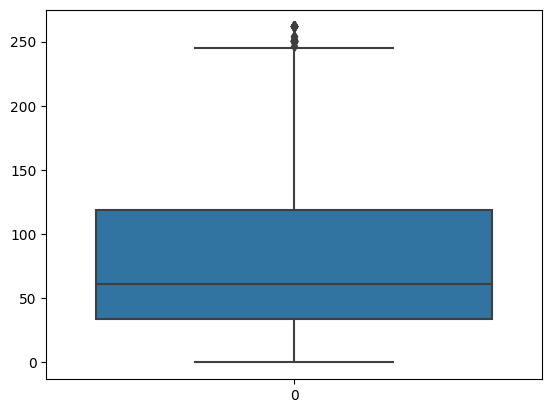

In [ ]:
sns.boxplot(lsc_load.Load);

> There are some oulier points

Check for data discription


In [ ]:
lsc_load.describe()

,Load
count,40895.000000
mean,80.324809
std,52.683940
min,0.000000
25%,34.250000
50%,61.130000
75%,118.855000
max,261.810000


In [ ]:
lsc_temp.describe()

,temp
count,13847.000000
mean,20.163097
std,8.605824
min,-9.400000
25%,13.900000
50%,21.700000
75%,26.100000
max,41.100000


Ploting a QQ plot: <br>
To determine whether the data is distributed into a certain way.
How data can fit a normal distrubution

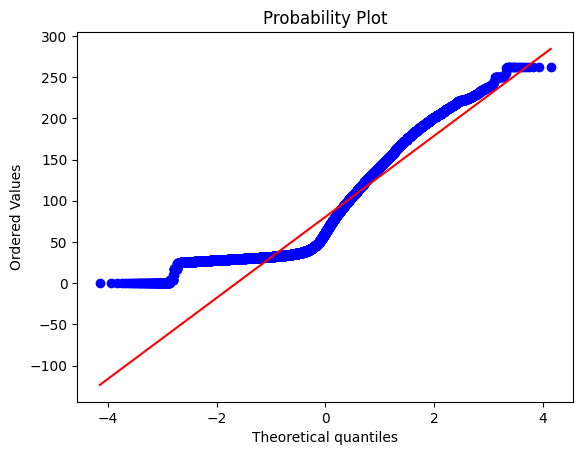

In [ ]:
## Quantile Quarter plot (QQ plot)
scipy.stats.probplot(lsc_load.Load,plot=pylab)
pylab.show()


> According to the QQ plot above
- There are more values around [0-50]; Data is not normally distributed.

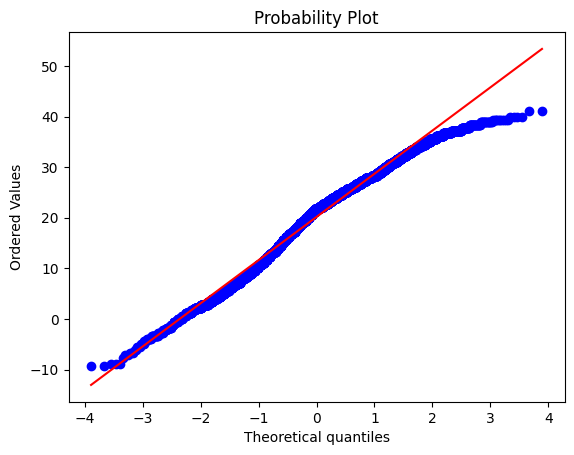

In [ ]:
scipy.stats.probplot(lsc_temp.temp,plot=pylab)
pylab.show()


- There are more values around 40 Data is not normally distributed.

### 1.2 Data Preparation

Create Date time index

In [ ]:
# convert the Datetime MST to datetime data type in utc timezone
lsc_load['Datetime MST']=pd.to_datetime(lsc_load['Datetime MST'],utc=True)
lsc_temp['time']=pd.to_datetime(lsc_temp['time'],utc=True)

In [ ]:
lsc_load['Datetime MST'].describe()

count                         40895
unique                        40895
top       2022-03-01 00:15:00+00:00
freq                              1
first     2022-03-01 00:15:00+00:00
last      2023-04-30 23:45:00+00:00
Name: Datetime MST, dtype: object

In [ ]:
lsc_temp['time'].describe()

count                         13847
unique                        13847
top       2021-10-01 01:00:00+00:00
freq                              1
first     2021-10-01 01:00:00+00:00
last      2023-04-30 23:00:00+00:00
Name: time, dtype: object

In [ ]:
lsc_load.set_index('Datetime MST',inplace=True)
lsc_load.head()

,Load
Datetime MST,
2022-03-01 00:15:00+00:00,85.38
2022-03-01 00:30:00+00:00,82.81
2022-03-01 00:45:00+00:00,81.88
2022-03-01 01:00:00+00:00,76.50
2022-03-01 01:15:00+00:00,76.75


In [ ]:
lsc_temp.set_index('time',inplace=True)
lsc_temp.head()

,temp
time,
2021-10-01 01:00:00+00:00,26.1
2021-10-01 02:00:00+00:00,25.0
2021-10-01 03:00:00+00:00,24.4
2021-10-01 04:00:00+00:00,23.9
2021-10-01 05:00:00+00:00,23.9


Setting the 15 minutes frequency

In [ ]:
lsc_copy=lsc_load.asfreq('15T')
lsc_temp=lsc_temp.asfreq('15T')

Check for missing values

In [ ]:
lsc_load.isna().sum()

Load    0
dtype: int64

In [ ]:
lsc_temp.isna().sum()

temp    41538
dtype: int64

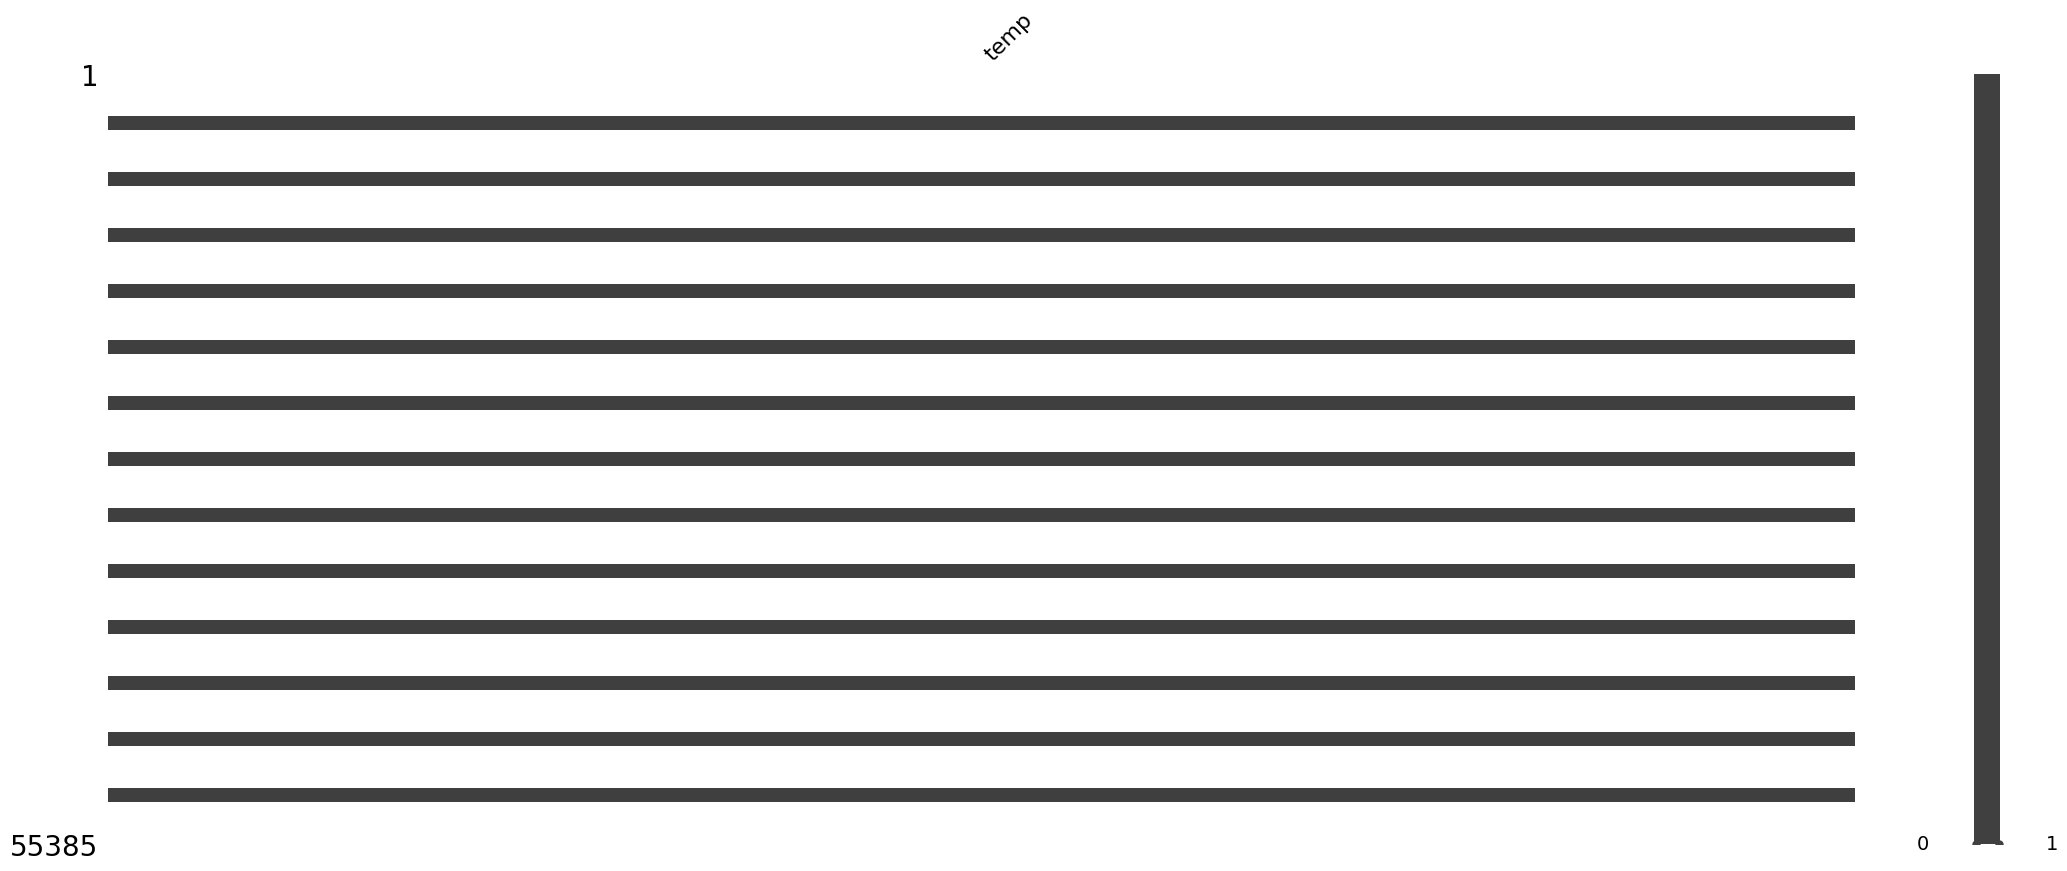

In [ ]:
msno.matrix(lsc_temp);

Load Data: <br>
Now, there are no load periods that were not included in the original set.
We have double checked that we have no missings.
<br>
<br>
Temperature Data: <br>
There is missing data after getting the 15 minutes temperatuer data, that needs to filled

Fill the missings data in the tempertature by front filling, hence we set the same value for every 15 minutes in the hour

In [ ]:
lsc_temp = lsc_temp.fillna(method="ffill")

In [ ]:
lsc_temp.head()

,temp
time,
2021-10-01 01:00:00+00:00,26.1
2021-10-01 01:15:00+00:00,26.1
2021-10-01 01:30:00+00:00,26.1
2021-10-01 01:45:00+00:00,26.1
2021-10-01 02:00:00+00:00,25.0


Merge the dataset

In [ ]:
df = lsc_load.merge(
    lsc_temp, left_index=True, right_index=True)
df.head()

,Load,temp
2022-03-01 00:15:00+00:00,85.38,17.8
2022-03-01 00:30:00+00:00,82.81,17.8
2022-03-01 00:45:00+00:00,81.88,17.8
2022-03-01 01:00:00+00:00,76.50,12.2
2022-03-01 01:15:00+00:00,76.75,12.2


### 1.3 Stationarity test

In [ ]:
sts.adfuller(df.Load)

(-17.492417145580887,
 4.4296090376658705e-30,
 54,
 40837,
 {'1%': -3.4305101418100357,
  '5%': -2.861610779041176,
  '10%': -2.5668076734036696},
 335667.72204107686)

Load Data <br>
We reject the null hypothesis, hence there a stationarity in the data set (the previous 54 lags to the current lag have identical cov)

In [ ]:
sts.adfuller(df.temp)

(-7.43720372624086,
 6.138682316774831e-11,
 52,
 40839,
 {'1%': -3.4305101339669504,
  '5%': -2.861610775574804,
  '10%': -2.5668076715586152},
 85175.75459719889)

Temp Data <br>
We reject the null hypothesis, hence there a stationarity in the data set (the previous 6 lags to the current lag have identical cov)

### 1.4 Seasonality Check
1. Additive

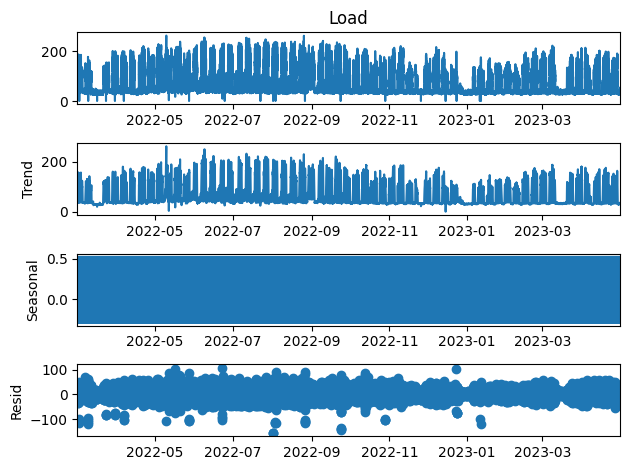

In [ ]:
# test
df_additive_compose = sm.tsa.seasonal_decompose(df.Load,period=15, model="additive")
df_additive_compose.plot();

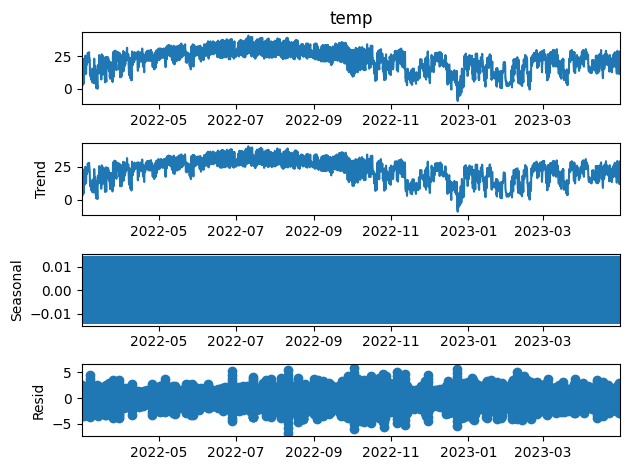

In [ ]:
# test
df_additive_compose = sm.tsa.seasonal_decompose(df.temp,period=15, model="additive")
df_additive_compose.plot();

The seasonal is rectangle, hence values are oscillating up and down from 5 to -5 in the temperature, and from 0.01 to -0.01 in the load data
> No cyclical pattern,hence no seasonality

> The residual is big hence the differences between true and predicted values for any period is significant

### 1.5 ACF


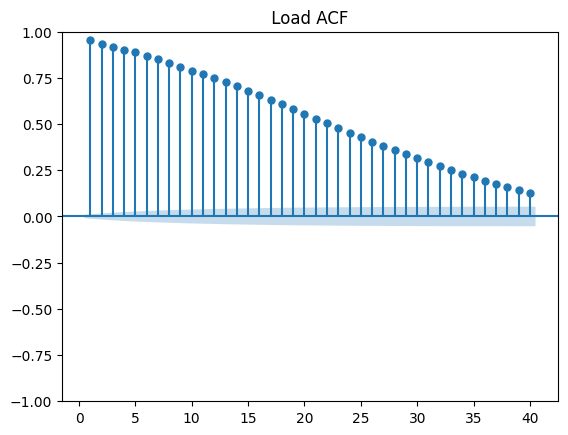

In [ ]:
sgt.plot_acf(df.Load,lags=40,zero=False);
plt.title(" Load ACF ");

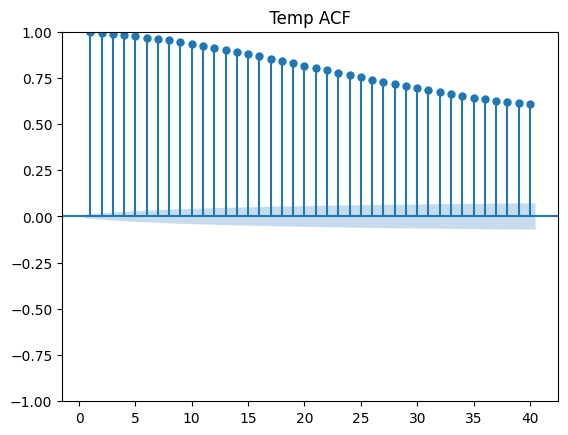

In [ ]:
sgt.plot_acf(df.temp,lags=40,zero=False);
plt.title(" Temp ACF ");


- The significance graph (blue shade) is not expanding, hence significance difference of higher lags isn't significantly different from zero

- We set the lags to 40, the autocorrelation starting from the very previous lag to the 40th lag is decreasing especially in the load data , hence moving away from the current lag and taking these vales for prediction isn't useful.

### 1.6 PACF <br>
Direct to the current lag , used to detect the number of lags used in the modeling

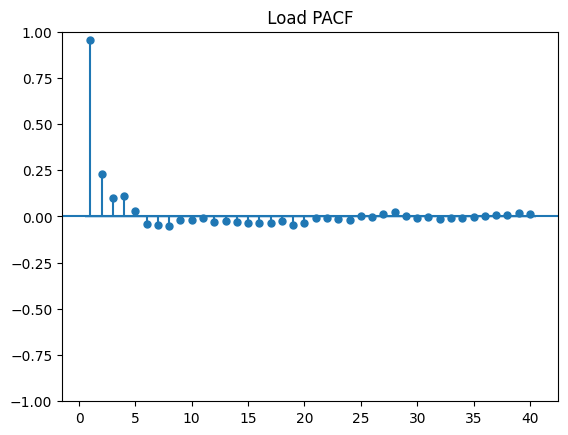

In [ ]:
# using the order of least squares method
sgt.plot_pacf(df.Load,lags=40,zero=False,method=('ols'));
plt.title(" Load PACF ");

The are lags starting from 6 lags ago resulted in lower values

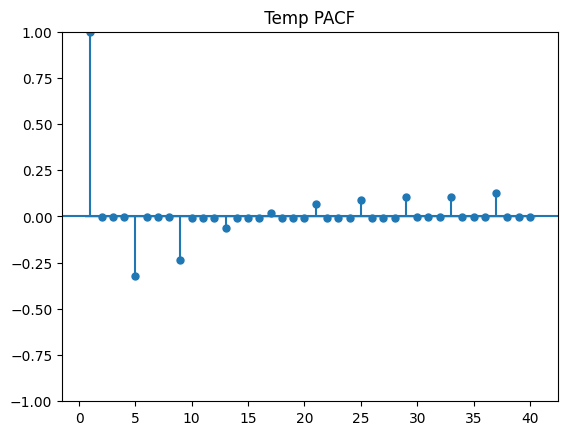

In [ ]:
sgt.plot_pacf(df.temp,lags=40,zero=False,method=('ols'));
plt.title(" Temp PACF ");

The are lags in the 5th, 9th lags ago resulted in significantly lower values.


- Overall, the blue curve is vanished, and that resembles all coefficients attached to these lags should be zero( lags to be omitted)
- number of lags used is 25 for temperature and 7 for the load data

## 2. Statistical Modeling


We need to construct a cutoff to split the data set at. <br>
We set the training set size of 80%



In [ ]:
size=int(len(df)*0.95)
train=df[:size]
test=df[size:]

Text(0.5, 1.0, 'Load Vs Temp values')

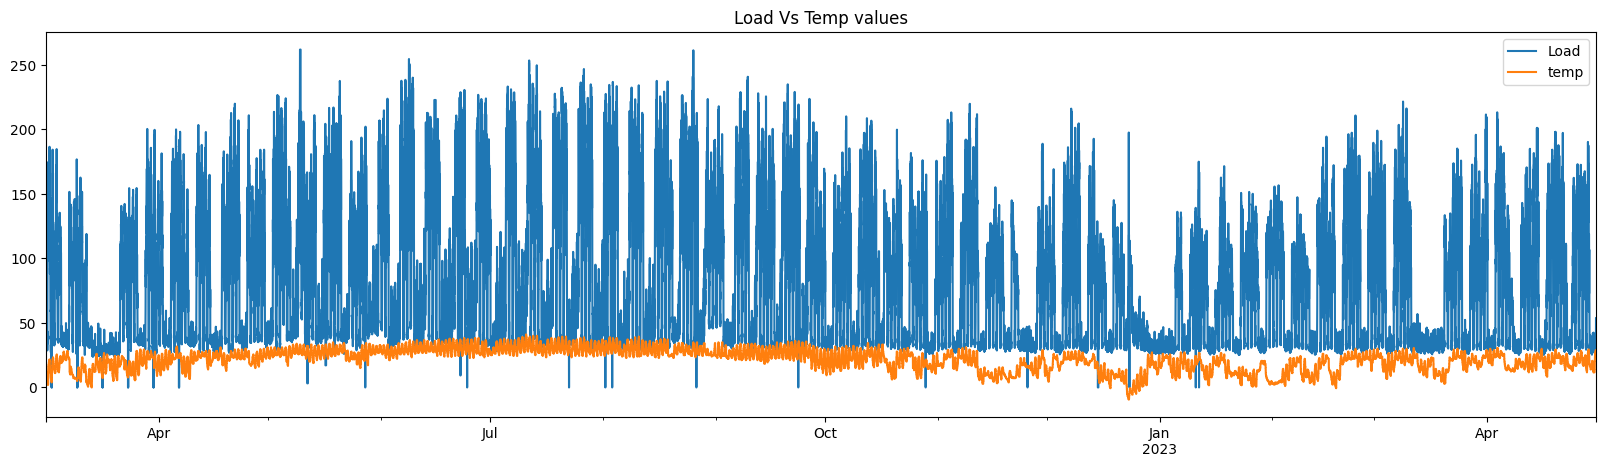

In [ ]:
plt.figure(figsize=(20,5))
df['Load'].plot();
df['temp'].plot();
plt.legend()
plt.title( "Load Vs Temp values")

In [ ]:
print("Training set ends at")
print(train.tail(1))
print("\nTesting set starts at")
print(test.head(1))


Training set ends at
                           Load  temp
2023-04-09 15:45:00+00:00  28.0  20.6

Testing set starts at
                            Load  temp
2023-04-09 16:00:00+00:00  27.13  21.1


The cutoff period is 2023-02-04 18:15

### 2.1 AR without Temperature




In [ ]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(train.Load, lags=7, trend='n',seasonal=False,).fit()
print(model.summary())
forecasts = model.forecast(len(test)).tolist()
test_values = test.Load.values.tolist()
difference=[]
for i in range(len(forecasts)):
  difference.append(forecasts[i] - test_values[i])


                            AutoReg Model Results                             
Dep. Variable:                   Load   No. Observations:                32713
Model:                     AutoReg(7)   Log Likelihood             -135728.815
Method:               Conditional MLE   S.D. of innovations             15.349
Date:                Sat, 24 Jun 2023   AIC                         271473.629
Time:                        17:40:47   BIC                         271540.792
Sample:                    03-01-2022   HQIC                        271495.091
                         - 02-04-2023                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Load.L1        0.7147      0.006    129.346      0.000       0.704       0.726
Load.L2        0.1358      0.007     19.994      0.000       0.123       0.149
Load.L3        0.0296      0.007      4.340      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


Having p-value =0 for c and the ar.L1 till ar.L7 resembles that they are significant different from zero. Having non zeros CI values , then the coefficients are significance.

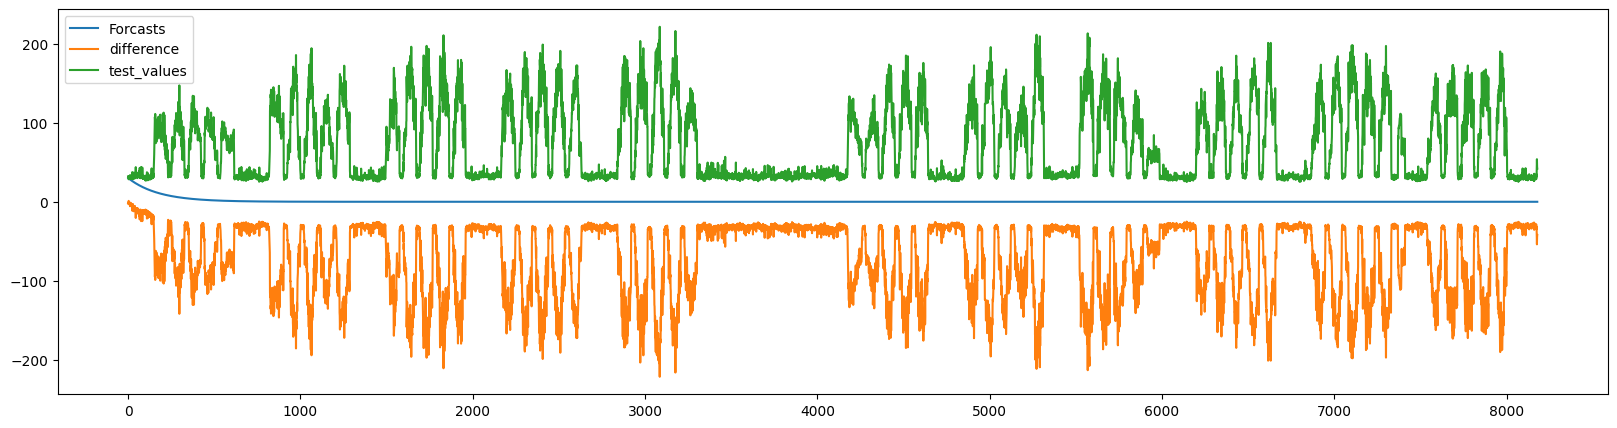

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(forecasts)
plt.plot(difference)
plt.plot(test_values)
plt.legend(['Forcasts','difference','test_values']);

### 2.2 AR with Temperature




In [ ]:
from statsmodels.tsa.api import VAR
model = VAR(train)
model.select_order(25)
results = model.fit(maxlags=25, ic='aic')
print(results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 24, Jun, 2023
Time:                     17:41:22
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    4.82503
Nobs:                     32688.0    HQIC:                   4.80720
Log likelihood:          -171095.    FPE:                    121.369
AIC:                      4.79883    Det(Omega_mle):         120.991
--------------------------------------------------------------------
Results for equation Load
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            3.115547         0.258598           12.048           0.000
L1.Load          0.689308         0.005537          124.501           0.000
L1.temp          0.590050         0.115199            5.122           0.000
L2.Lo

In [ ]:
results.forecast(test.values,len(test))

array([[44.82761219, 28.89277288],
       [47.66521141, 28.87324152],
       [49.61652126, 28.87017203],
       ...,
       [82.20636784, 22.32596047],
       [82.20636784, 22.32596047],
       [82.20636784, 22.32596047]])

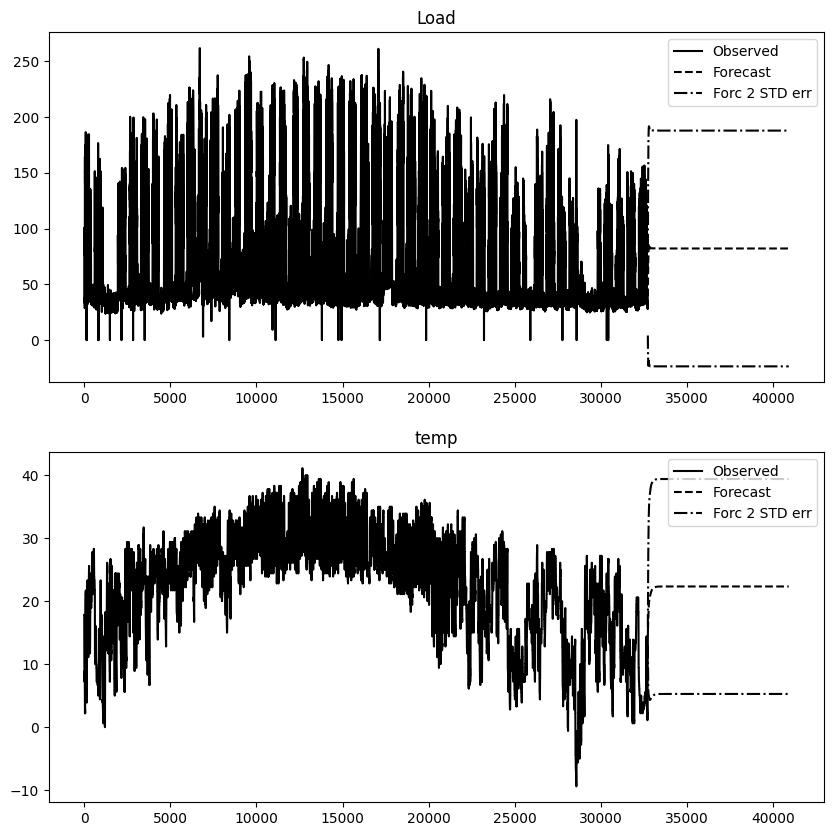

In [ ]:
from numpy import savetxt
#savetxt('forcasting.csv', results.forecast(test.values,test.shape[0]), delimiter=',')
results.plot_forecast(test.shape[0]);

AR model is simple to capture any pattern in our data, we won't try MA and we are going to try ARIMA in the next cells

### 2.3 LLR Test <br>
Showing if models are significanlty different or not


In [ ]:
'''
# create lagged variables for load and temperature
p = 25 # order of the AR model
q = 7 # number of lags of temperature to include
Y = df.Load[p:]
X = np.column_stack([df.Load.shift(i)[p:] for i in range(1, p+1)] + [df.temp.shift(i)[p:] for i in range(1, q+1)])
X = sm.add_constant(X)

# fit the AR model using OLS regression
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

# forecast future values of the load given future values of temperature
forecast_periods = 12 # number of periods to forecast
forecast_X = np.column_stack([df.Load[-p+i:] for i in range(1, p+1)] + [df.temp[-q+i:] for i in range(1, q+1)])
forecast_X = sm.add_constant(forecast_X)
forecast_load = results.predict(forecast_X)
'''


'\n# create lagged variables for load and temperature\np = 25 # order of the AR model\nq = 7 # number of lags of temperature to include\nY = df.Load[p:]\nX = np.column_stack([df.Load.shift(i)[p:] for i in range(1, p+1)] + [df.temp.shift(i)[p:] for i in range(1, q+1)])\nX = sm.add_constant(X)\n\n# fit the AR model using OLS regression\nmodel = sm.OLS(Y, X)\nresults = model.fit()\nprint(results.summary())\n\n# forecast future values of the load given future values of temperature\nforecast_periods = 12 # number of periods to forecast\nforecast_X = np.column_stack([df.Load[-p+i:] for i in range(1, p+1)] + [df.temp[-q+i:] for i in range(1, q+1)])\nforecast_X = sm.add_constant(forecast_X)\nforecast_load = results.predict(forecast_X)\n'

In [ ]:
'''
plt.figure(figsize=(20,5))
plt.plot(df.Load)
plt.plot(np.arange(len(df.Load), len(df.Load)+forecast_periods), forecast_load)
plt.show()
'''

### 2.4 Auto ARIMA without Temprature



In [ ]:
#!pip install pmdarima


In [ ]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['Load'],trace=True,stepwise=True
,suppress_warnings=True,seasonal=False,stationary=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=337190.157, Time=34.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=440267.573, Time=0.75 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=340123.614, Time=0.95 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=402041.998, Time=10.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=489393.134, Time=0.35 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=337199.590, Time=17.60 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=337190.365, Time=21.59 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=336883.608, Time=68.84 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=337187.855, Time=34.13 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=336797.745, Time=47.08 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=336992.670, Time=42.92 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=336794.600, Time=78.96 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=336957.394, Time=59.53 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=336800.731, Time=72.2

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model=sm.tsa.arima.ARIMA(train['Load'],order=(2,0,4))
model=model.fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Load   No. Observations:                32713
Model:                 ARIMA(2, 0, 4)   Log Likelihood             -135523.927
Date:                Sat, 24 Jun 2023   AIC                         271063.854
Time:                        18:07:24   BIC                         271131.018
Sample:                    03-01-2022   HQIC                        271085.316
                         - 02-04-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.1779      2.477     33.176      0.000      77.323      87.033
ar.L1          1.9274      0.006    346.260      0.000       1.916       1.938
ar.L2         -0.9302      0.005   -170.729      0.000      -0.941      -0.920
ma.L1         -1.2277      0.006   -189.249      0.000      -1.240      -1.215
ma.L2          0.2032      0.006     35.525      0.000       0.192       0.214
ma.L3          0.0105      0.005      1.945      0.052   -8.01e-05       0.021
ma.L4          0.0783      0.004     21.600      0.000       0.071       0.085
sigma2       232.2235      0.741    313.339      0.000     230.771     233.676
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            300513.95
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Model prediction on the testing set

<Axes: >

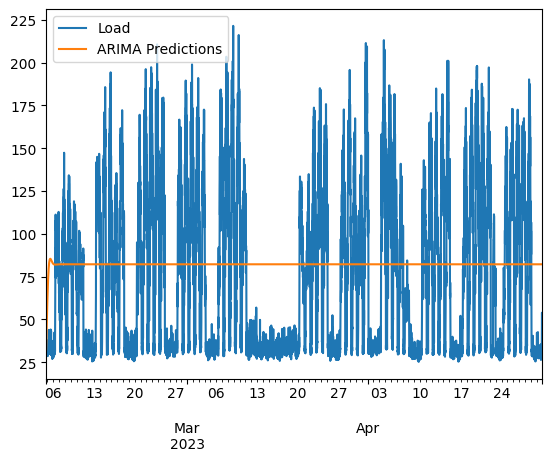

In [ ]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
test['Load'].plot(legend=True)
pred.plot(legend=True)


Model is overfitting

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['Load'].mean()
rmse=sqrt(mean_squared_error(pred,test['Load']))
print(rmse)

47.71886083899532


### 2.5 Auto ARIMA with Temprature



In [ ]:
# Define the exogenous variable
exog_train = train[['temp']]
exog_test = test[['temp']]

In [ ]:
'''
stepwise_fit = auto_arima(train['Load'],exog_train, trace=True,stepwise=True,max_p=25,max_q=25
,suppress_warnings=True)
'''

In [ ]:
stepwise_fit = auto_arima(train['Load'],exog_train, trace=True,stepwise=True
,suppress_warnings=True,seasonal=False,stationary=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=271396.015, Time=38.41 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=348929.292, Time=3.67 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=273664.843, Time=4.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=319300.141, Time=14.61 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=350598.528, Time=6.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=271406.208, Time=24.41 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=271398.049, Time=16.38 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=271063.218, Time=61.09 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=271392.694, Time=37.03 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=271133.297, Time=63.56 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=271163.101, Time=63.84 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=271348.759, Time=60.51 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=271256.940, Time=38.32 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=271128.375, Time=71.9

In [ ]:
model=sm.tsa.arima.ARIMA(train['Load'], order=(3,0,2), exog=exog_train)
model=model.fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Load   No. Observations:                38847
Model:                 ARIMA(3, 0, 2)   Log Likelihood             -160035.111
Date:                Sun, 25 Jun 2023   AIC                         320086.221
Time:                        09:36:14   BIC                         320154.760
Sample:                    03-01-2022   HQIC                        320107.946
                         - 04-09-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.6031      3.425      9.812      0.000      26.891      40.316
temp           1.5509      0.083     18.702      0.000       1.388       1.713
ar.L1          2.2640      0.009    261.435      0.000       2.247       2.281
ar.L2         -1.5820      0.016    -96.503      0.000      -1.614      -1.550
ar.L3          0.3163      0.008     38.334      0.000       0.300       0.332
ma.L1         -1.5789      0.008   -208.772      0.000      -1.594      -1.564
ma.L2          0.6203      0.007     84.361      0.000       0.606       0.635
sigma2       221.6226      0.667    332.455      0.000     220.316     222.929
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):            316227.57
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Model prediction on the testing set

<Axes: >

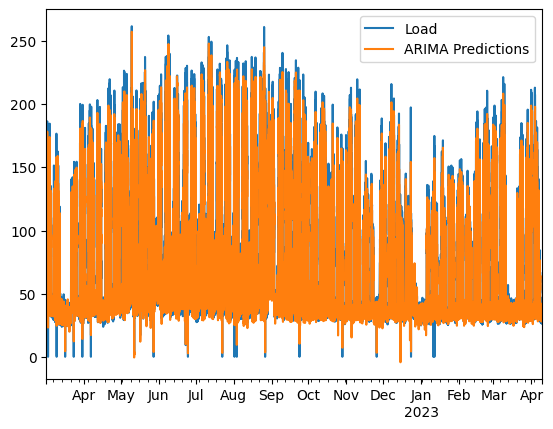

In [ ]:
start=0
end=len(train)-1
pred=model.predict(start=start,end=end,typ='levels',exog=exog_train).rename('ARIMA Predictions')
train['Load'].plot(legend=True)
pred.plot(legend=True)

<Axes: >

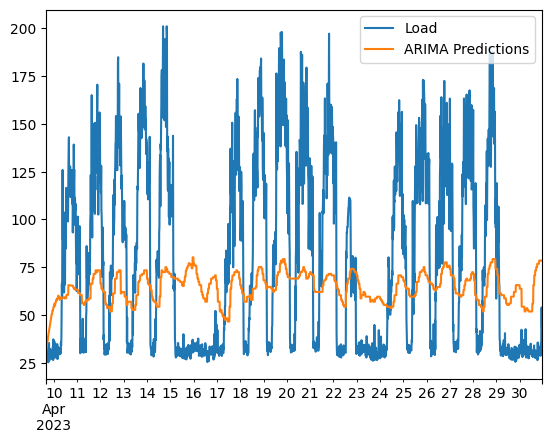

In [ ]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels',exog=exog_test).rename('ARIMA Predictions')
test['Load'].plot(legend=True)
pred.plot(legend=True)

Model is overfitting

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['Load'].mean()
rmse=sqrt(mean_squared_error(pred,test['Load']))
print(rmse)

45.42727717202703


In [ ]:
'''
model = pm.auto_arima(final_df['demand'],
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',
                           suppress_warnings=True,
                      stepwise=True, trace=True)
'''

### 2.6 Exponential Smoothing

As along with previous analysis done before, data had no seasonlaity or trend, hence we can use the Exponential Smoothing Method

In [ ]:

plt.style.use('Solarize_Light2')

r = requests.get('https://datamarket.com/api/v1/list.json?ds=22qx')
jobj = json.loads(r.text[18:-1])
data = jobj[0]['data']
df = pd.DataFrame(data, columns=['time','data']).set_index('time')
train = df.iloc[100:-10, :]
test = df.iloc[-10:, :]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()

model = SimpleExpSmoothing(np.asarray(train['data']))
model._index = pd.to_datetime(train.index)

fit1 = model.fit()
pred1 = fit1.forecast(9)
fit2 = model.fit(smoothing_level=.2)
pred2 = fit2.forecast(9)
fit3 = model.fit(smoothing_level=.5)
pred3 = fit3.forecast(9)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[150:], train.values[150:])
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title("Simple Exponential Smoothing")
plt.legend();

model = Holt(np.asarray(train['data']))
model._index = pd.to_datetime(train.index)

fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(9)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(9)
fit3 = model.fit(smoothing_level=.3, smoothing_slope=.2)
pred3 = fit3.forecast(9)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[150:], train.values[150:])
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
plt.title("Holt's Exponential Smoothing")
plt.legend();

### 2.7 Regression

In [ ]:
'''
from sia_ts_modelling.automate import pipeline
from sklearn.ensemble import RandomForestRegressor


(benchmarking_df, all_models, prediction_all_models,) = pipeline(
    input_df=df_load_temperature_holidays.dropna(),
    target_column="Historical_consumption",
    features_sets={
        "temperature_only": ["Historical_temperature_smoothed"],
        "temperature_day_month": [
            "Historical_temperature_smoothed",
            "day_of_week",
            "month",
        ],
        "temperature_day_month_hour": [
            "Historical_temperature_smoothed",
            "hour",
            "day_of_week",
            "month",
        ],
    },
    model_and_init_params=[
        {
            "name": "my_first_lasso",
            "model": "lasso",
            "features_sets": ["temperature_only", "temperature_day_month"],
            "model_by_moment": True,
            "period_moment": "hour",
        },
        {
            "name": "my_first_rf",
            "model": RandomForestRegressor,
            "features_sets": ["temperature_only"],
            "kwargs_build": {"n_estimators": 10},
            "model_by_moment": True,
            "period_moment": "hour",
        },
        {
            "name": "my_first_gam",
            "model": "gam",
            "features_sets": ["temperature_day_month"],
            "kwargs_build": {
                "s_terms": [
                    {
                        "feature": "Historical_temperature_smoothed",
                        "extra_kwargs": {"n_splines": 13},
                    },
                ],
                "f_terms": [
                    {
                        "feature": "day_of_week",
                    },
                    {
                        "feature": "month",
                    },
                ],
            },
            "model_by_moment": True,
            "period_moment": "hour",
        },
        {
            "name": "aggregate_model",
            "features_sets": ["temperature_day_month_hour"],
            "model": {"my_lasso": "lasso", "my_rf": RandomForestRegressor},
            "kwargs_build": {
                "weights": "trained",
                "my_rf": {"n_estimators": 10},
            },
            "model_by_moment": False,
            "period_moment": "hour",
        },
    ],
    train_test_split_method="split_proportion",
    test_size=0.25,
    metrics=["MAPE", "R2", "MSE"],
)
'''

### 2.8 Prophet

## 3. LSTM

### 3.1 LSTM with Temperature

Data Scaling

In [76]:
X, y = df.drop(columns=['Load']), df.Load.values
X.shape, y.shape

((40892, 1), (40892,))

In [77]:

mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X.values.reshape(-1, 1))
y_trans = mm.fit_transform(y.reshape(-1, 1))

 We want to feed in 7 samples, up to the current lag, and predict the next 5 time step values

In [78]:
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 7, 5)
print(X_ss.shape, y_mm.shape)

(40882, 7, 1) (40882, 5)


In [82]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

X_train = X_ss[:train_test_cutoff]
X_test = X_ss[train_test_cutoff:]

y_train = y_mm[:train_test_cutoff]
y_test = y_mm[train_test_cutoff:]

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)


Training Shape: (36803, 7, 1) (36803, 5)
Testing Shape: (4079, 7, 1) (4079, 5)


In [83]:
# convert to pytorch tensors
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

In [85]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,
                                      (X_train_tensors.shape[0], 7,
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,
                                     (X_test_tensors.shape[0], 7,
                                      X_test_tensors.shape[2]))

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape: torch.Size([36803, 7, 1]) torch.Size([36803, 5])
Testing Shape: torch.Size([4079, 7, 1]) torch.Size([4079, 5])


The size of the input is then (𝑁,𝐿,𝐻_𝑖𝑛), where 𝑁 is the batch size, 𝐿 is the sequence length,
 and 𝐻_𝑖𝑛 is the input size (i.e. the number of features).
the rows of the dataframe in the first dimension,
 followed by the length of the dataframe in the next dimension
 (representing the length of the input sequence),
 and finally the features (of which we have four) in the final dimension.

take the 100 previous predictors up to the current time-step, and predict 50 time-steps into the future.
we have 150 batch feature samples, each consisting of 100 time-steps and the temperature feature predictors. In the targets for the test set, we again have 150 batch samples, each consisting of an array of length 50 of scalar outputs.

Model Construction

In [86]:

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()

    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch,
                                                                      loss.item(),
                                                                      test_loss.item()))


In [87]:
n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 1 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 5 # number of output classes

lstm = LSTM(num_classes,
              input_size,
              hidden_size,
              num_layers)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [88]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.16715, test loss: 0.13456
Epoch: 100, train loss: 0.03551, test loss: 0.02965
Epoch: 200, train loss: 0.03384, test loss: 0.02903
Epoch: 300, train loss: 0.03358, test loss: 0.02870
Epoch: 400, train loss: 0.03344, test loss: 0.02855
Epoch: 500, train loss: 0.03337, test loss: 0.02844
Epoch: 600, train loss: 0.03330, test loss: 0.02835
Epoch: 700, train loss: 0.03317, test loss: 0.02823
Epoch: 800, train loss: 0.03288, test loss: 0.02793
Epoch: 900, train loss: 0.03259, test loss: 0.02743


In [89]:
df_X_ss = ss.transform(df.drop(columns=['Load'])) # old transformers
df_y_mm = mm.transform(df.Load.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 7, 5)
# converting to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 7, df_X_ss.shape[2]))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [90]:
train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()
data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

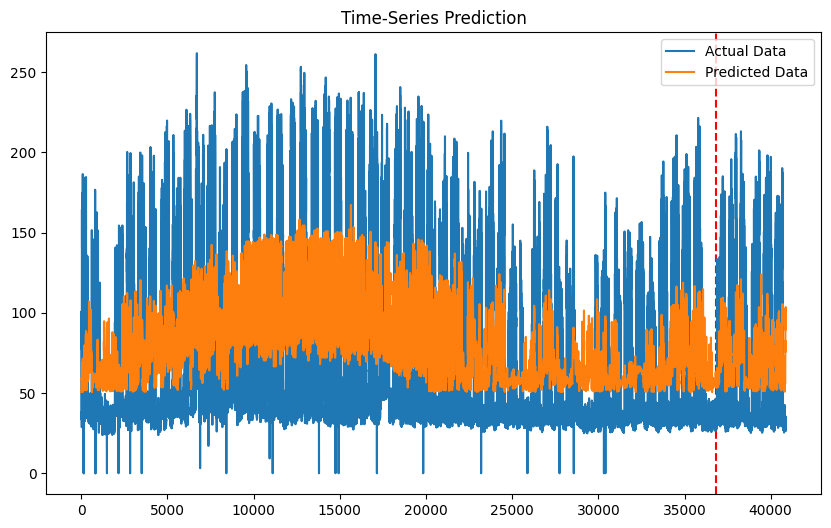

In [91]:
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show()

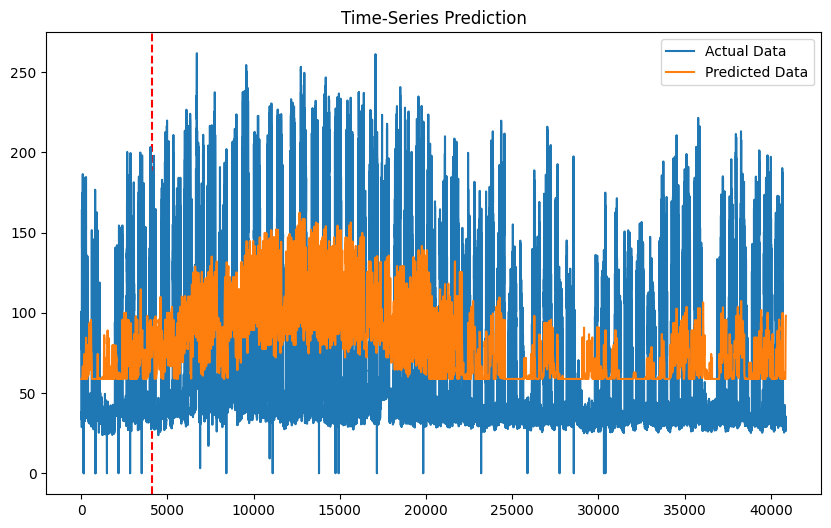

In [73]:
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show()


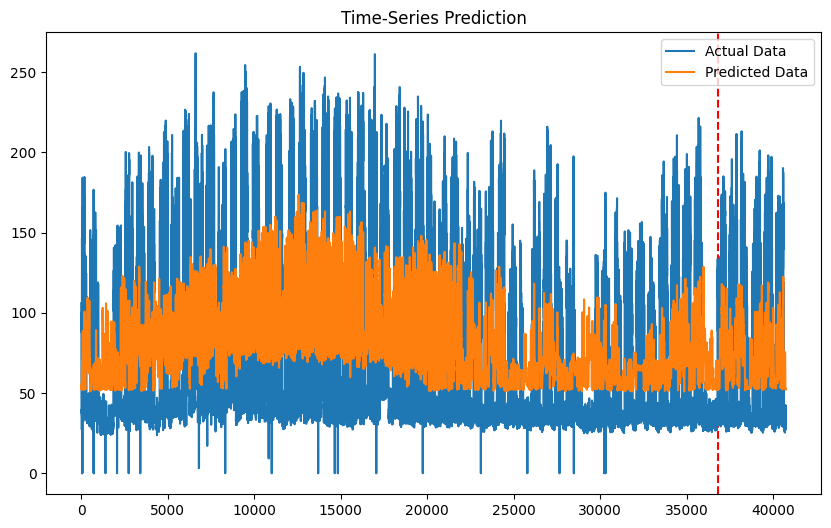

In [50]:
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show()
